# Train Keras OCR with Ionograms

In the last Notebook, I tried to train Keras OCR with synthetic data, but the results weren't conclusive. The goal here is to train Keras OCR with the text that is already on the ionograms. Here are the refences :
https://keras-ocr.readthedocs.io/en/latest/examples/fine_tuning_recognizer.html
https://stackoverflow.com/questions/52004133/how-to-improve-image-quality
https://stackoverflow.com/questions/39308030/how-do-i-increase-the-contrast-of-an-image-in-python-opencv

In [1]:
data_dir = 'L:/DATA/ISIS/keras_ocr/'

import os
import math
import imgaug
import numpy as np
import matplotlib.pyplot as plt
import sklearn.model_selection
import tensorflow as tf
import datetime

import keras_ocr

## Train the recognizer
After some research, training the detector seems hard and time consuming, so we'll start by training the recognizer with our own pictures. To train the recognizer, we need small images of digits from ionograms. I cropped 60 ionograms and their metadata. After doing some tests, I came to realize that the detector was working better when the images are only black and white, so I did a little bit of pre-processing (see the Notebook *Pre-process training images*). Here how it looks like.

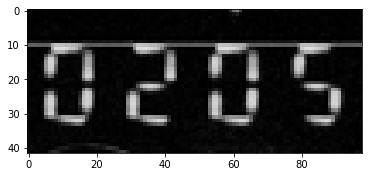

In [2]:
im = plt.imread(data_dir+'test_images/cropped/20-5.png')
plt.imshow(im)

I also created a txt file with the name of the images and the right numbers. It looks like this.

In [4]:
import pandas as pd

dataset = pd.read_csv(data_dir+'test_images/cropped/annotations.txt', header=None, 
                      names=['file','text'], dtype={'file' : str, 'text' : str})
dataset['file'] = data_dir+'test_images/cropped/' + dataset['file']
dataset['text'] = dataset['text'].astype(str)
dataset.insert(1, 'empty', None)
dataset = dataset.sample(frac=1)

dataset.head(6)

,file,empty,text
66,L:/DATA/ISIS/keras_ocr/test_images/cropped/12-...,None,45
242,L:/DATA/ISIS/keras_ocr/test_images/cropped/41-...,None,71
241,L:/DATA/ISIS/keras_ocr/test_images/cropped/41-...,None,00
15,L:/DATA/ISIS/keras_ocr/test_images/cropped/3-4...,None,101
64,L:/DATA/ISIS/keras_ocr/test_images/cropped/11-...,None,0203
18,L:/DATA/ISIS/keras_ocr/test_images/cropped/4-1...,None,36


We now divide the images for training and testing.

In [5]:
train_subset, test_subset = sklearn.model_selection.train_test_split(dataset, test_size=0.2)

train_subset.reset_index(inplace=True, drop=True)
test_subset.reset_index(inplace=True, drop=True)

train = []
for i in range(len(train_subset)):
    train.append(tuple(train_subset.loc[i].to_list()))

test = []
for i in range(len(test_subset)):
    test.append(tuple(test_subset.loc[i].to_list()))

We specify that our alphabet is only numbers.

In [6]:
import string
recognizer = keras_ocr.recognition.Recognizer(alphabet=string.digits)
recognizer.model.load_weights('L:/DATA/ISIS/keras_ocr/ISIS_reading.h5')
recognizer.compile()

Provided alphabet does not match pretrained alphabet. Using backbone weights only.
Looking for C:\Users\mfortier\.keras-ocr\crnn_kurapan_notop.h5


We divide the training images in training and validation.

In [7]:
batch_size = 1
augmenter = imgaug.augmenters.Sequential([
    imgaug.augmenters.GammaContrast(gamma=(0.25, 3.0)),
])

(training_image_gen, training_steps), (validation_image_gen, validation_steps) = [
    (
        keras_ocr.datasets.get_recognizer_image_generator(
            labels=labels,
            height=recognizer.model.input_shape[1],
            width=recognizer.model.input_shape[2],
            alphabet=recognizer.alphabet,
            augmenter=augmenter
        ),
        len(labels) // batch_size
    ) for labels, augmenter in [(train, augmenter), (test, None)]
]
training_gen, validation_gen = [
    recognizer.get_batch_generator(
        image_generator=image_generator,
        batch_size=batch_size
    )
    for image_generator in [training_image_gen, validation_image_gen]
]

288 / 288 instances have illegal characters.
text: 16


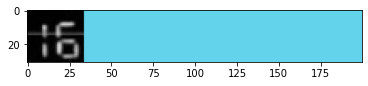

In [8]:
image, text = next(training_image_gen)
print('text:', text)
plt.imshow(image)

Time for the training to begin!

In [9]:
recognizer_basepath = os.path.join('L:/DATA/ISIS/keras_ocr/', f'recognizer_{datetime.datetime.now().isoformat()}')
callbacks=[
    tf.keras.callbacks.EarlyStopping(restore_best_weights=False, patience=10),
    tf.keras.callbacks.CSVLogger(f'{recognizer_basepath}.csv', append=True),
    tf.keras.callbacks.ModelCheckpoint(filepath=f'{recognizer_basepath}.h5')        
    ]
recognizer.training_model.fit(
    training_gen,
    steps_per_epoch=training_steps,
    validation_steps=validation_steps,
    validation_data=validation_gen,
    callbacks=callbacks,
    epochs=1000,
    workers=0,
    batch_size=batch_size
)

Epoch 1/1000
288/288 [==============================] - 59s 163ms/step - loss: 0.1023 - val_loss: 0.3090
Epoch 2/1000
288/288 [==============================] - 41s 144ms/step - loss: 0.1484 - val_loss: 0.1441
Epoch 3/1000
288/288 [==============================] - 41s 144ms/step - loss: 0.0705 - val_loss: 0.0011
Epoch 4/1000
288/288 [==============================] - 40s 141ms/step - loss: 0.1051 - val_loss: 0.0879
Epoch 5/1000
288/288 [==============================] - 41s 141ms/step - loss: 0.0750 - val_loss: 0.3830
Epoch 6/1000
288/288 [==============================] - 48s 165ms/step - loss: 0.2334 - val_loss: 0.0047
Epoch 7/1000
288/288 [==============================] - 39s 136ms/step - loss: 0.0545 - val_loss: 0.0038
Epoch 8/1000
288/288 [==============================] - 37s 130ms/step - loss: 0.0392 - val_loss: 0.0201
Epoch 9/1000
288/288 [==============================] - 41s 143ms/step - loss: 0.0728 - val_loss: 5.4278e-05
Epoch 10/1000
288/288 [============================

Test a couple of images with our improved recognizer

1/1 [==============================] - 2s 2s/step
Predicted: 16, Actual:  16


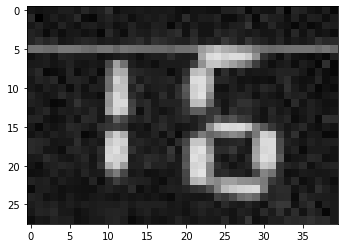

In [10]:
image_filepath, _, actual = test[0]
predicted = recognizer.recognize(image_filepath)
print(f'Predicted: {predicted}, Actual: {actual}')
_ = plt.imshow(keras_ocr.tools.read(image_filepath))

1/1 [==============================] - 0s 115ms/step
Predicted: 05, Actual:  05


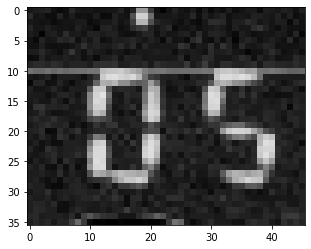

In [11]:
image_filepath, _, actual = test[1]
predicted = recognizer.recognize(image_filepath)
print(f'Predicted: {predicted}, Actual: {actual}')
_ = plt.imshow(keras_ocr.tools.read(image_filepath))

1/1 [==============================] - 0s 81ms/step
Predicted: 065, Actual:  065


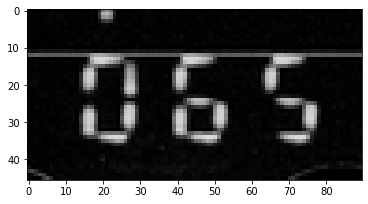

In [12]:
image_filepath, _, actual = test[2]
predicted = recognizer.recognize(image_filepath)
print(f'Predicted: {predicted}, Actual: {actual}')
_ = plt.imshow(keras_ocr.tools.read(image_filepath))

Let's test it on real ionograms picked at random.

In [13]:
from random import randrange
def draw_random_subdir(dataDir):
    directory_list = os.listdir(dataDir)
    directory = directory_list[randrange(len(directory_list))]
    subdirectory_list = os.listdir(dataDir + directory + '/')
    subdirectory = subdirectory_list[randrange(len(subdirectory_list))]
    image_list = os.listdir(dataDir + directory + '/'+subdirectory+'/')
    image = image_list[randrange(len(image_list))]    
    return directory, subdirectory, image

import cv2

def change_contrast(path_image,a=1.8,b=-50):
    im = cv2.imread(path_image)
    alpha=a
    beta=b
    im = cv2.addWeighted(im,a,im,0,b)
    #cv2.imwrite(save_dir+name_image,im)  
    return(im)

In [31]:
dataDir = 'L:/DATA/ISIS/raw_upload_20230421/'
img_list=[]
img_path=[]
for i in range(3):
    directory, subdirectory, image = draw_random_subdir(dataDir)
    img_list.append(image)
    img_path.append(dataDir + directory + '/' + subdirectory + '/' + image)

In [32]:
img_path

['L:/DATA/ISIS/raw_upload_20230421/R014207872/B1-35-15 ISIS B D-117/Image0357.png',
 'L:/DATA/ISIS/raw_upload_20230421/R014207767/B1-35-26 ISIS B D-781/Image0004.png',
 'L:/DATA/ISIS/raw_upload_20230421/R014207872/B1-35-15 ISIS B D-137/Image0079.png']

We need to apply a filter to improve the results.

In [33]:
new_img=[]
for im in img_path:
    new = change_contrast(im)
    new_img.append(new)

Pass the images to the recognizer.

Looking for C:\Users\mfortier\.keras-ocr\craft_mlt_25k.h5
1/1 [==============================] - 0s 389ms/step


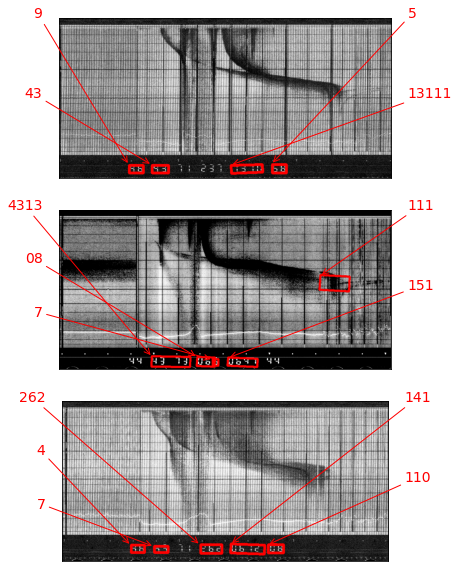

In [34]:
pipeline = keras_ocr.pipeline.Pipeline(recognizer=recognizer)
prediction_groups = pipeline.recognize(new_img)
# plot the text predictions
fig, axs = plt.subplots(nrows=len(new_img), figsize=(15, 10))
for ax, image, predictions in zip(axs, new_img, prediction_groups):
    keras_ocr.tools.drawAnnotations(image=image, 
                                    predictions=predictions, 
                                    ax=ax)

Let's see the results if the images are cropped.

1/1 [==============================] - 0s 377ms/step


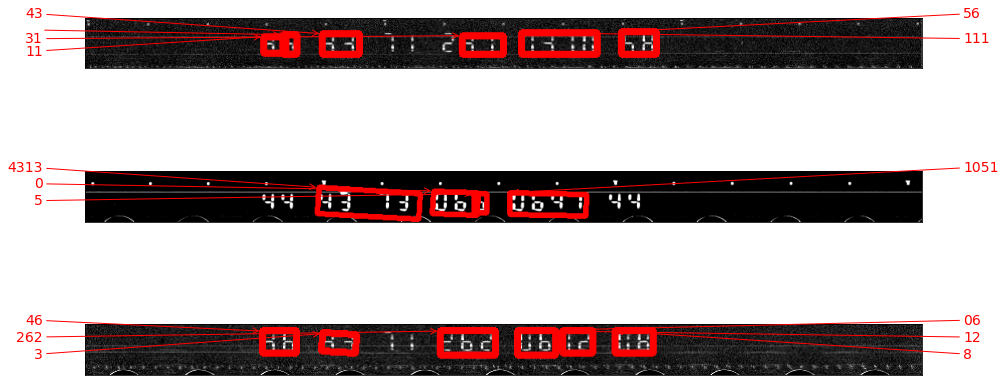

In [35]:
crop_img=[]
for i,im in enumerate(new_img) :
    height, width, _ = im.shape
    im = im[int(height-height*0.125):height,0:width]
    crop_img.append(im)
prediction_groups = pipeline.recognize(crop_img)
# plot the text predictions
fig, axs = plt.subplots(nrows=len(crop_img), figsize=(15, 8))
for ax, image, predictions in zip(axs, crop_img, prediction_groups):
    keras_ocr.tools.drawAnnotations(image=image, 
                                    predictions=predictions, 
                                    ax=ax)

In [36]:
numbers = list(zip(*prediction_groups[0]))[0]
print(numbers)

('56', '111', '', '43', '11', '31')


In [37]:
numbers = list(zip(*prediction_groups[1]))[0]
print(numbers)

('4313', '0', '5', '1051')


In [38]:
numbers = list(zip(*prediction_groups[2]))[0]
print(numbers)

('46', '262', '06', '12', '8', '3')


Save the trained recognizer.

In [39]:
#recognizer.model.save_weights(data_dir +'ISIS_reading_v2.h5')